In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/25-1 부동산 허위매물 분류 해커톤/데이터/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/25-1 부동산 허위매물 분류 해커톤/데이터/test.csv')

In [ ]:
df = train.copy()

## EDA

### 1. 빈도수 기반 인코딩
- 중개사무소, 제공플랫폼 각각에 해당하는 범주형 변수를 frequency로 인코딩

In [ ]:
# 중개사무소
agency_freq = df['중개사무소'].value_counts()
df['중개사무소_freq'] = df['중개사무소'].map(agency_freq)

# 제공플랫폼
platform_freq = df['제공플랫폼'].value_counts()
df['제공플랫폼_freq'] = df['제공플랫폼'].map(platform_freq)

### 2. 방향 사이클 인코딩
- 방향을 각도로 변환
- sin, cos 로 변환

In [ ]:
import re

def clean_direction(val):
    if pd.isnull(val):
        return None
    # 여러 방향이 있다면 첫 번째 방향만 추출
    val = re.split(r'[/,\s]', val)[0]
    # 불필요한 단어 제거
    val = val.replace('향', '').strip()
    return val

df['방향_정리'] = df['방향'].apply(clean_direction)

In [ ]:
direction_to_angle = {
    '동': 0,
    '남동': 45,
    '남': 90,
    '남서': 135,
    '서': 180,
    '북서': 225,
    '북': 270,
    '북동': 315
}

df['방향_angle'] = df['방향_정리'].map(direction_to_angle)


df['방향_sin'] = np.sin(np.deg2rad(df['방향_angle']))
df['방향_cos'] = np.cos(np.deg2rad(df['방향_angle']))

### 3. 매개등록일 파생변수 생성
- 기준일을 0402로 잡고 경과일 계산

In [ ]:
from datetime import datetime

df['게재일'] = pd.to_datetime(df['게재일'])
today = pd.to_datetime('today')
df['등록후경과일'] = (today - df['게재일']).dt.days

### 4. 결측치 처리
- 결측치 개수를 포함하는 컬럼 생성
- 방수, 욕실수는 최빈값으로 대체
- 전용면적, 해당층, 총층, 총주차대수는 중앙값으로 대체

In [ ]:
df['결측치_개수'] = df.isnull().sum(axis=1)

In [ ]:
mode_cols = ['방수', '욕실수']

for col in mode_cols:
    df[col].fillna(df[col].mode().iloc[0], inplace=True)

In [ ]:
median_cols = ['전용면적', '해당층', '총층', '총주차대수']
for col in median_cols:
    df[col].fillna(df[col].median(), inplace=True)

### 5. 게재일 변수 정리
- 게재일을 datetime으로 변환 후 등록일, 등록월, 등록연, 등록분기라는 새로운 컬럼 생성

In [ ]:
df['게재일'] = pd.to_datetime(df['게재일'], errors='coerce')

In [ ]:
df['등록연'] = df['게재일'].dt.year
df['등록월'] = df['게재일'].dt.month
df['등록일'] = df['게재일'].dt.day
df['등록분기'] = df['게재일'].dt.quarter

### 6. 중개사무소 분리
- 허위매물이 하나도 없던 'G52Iz8V2B9'를 기준으로 데이터 분리
- G52Iz8V2B9에 해당하는 데이터는 테스트에서 모두 0으로 예측할 것이라고 판단
- 두 테이블을 따로 학습, 예측할 예정

In [ ]:
target_agency = 'G52Iz8V2B9'

df_g52 = df[df['중개사무소'] == target_agency].copy()
df_other = df[df['중개사무소'] != target_agency].copy()

### 6. Drop 정리
- 방향, 방향_angle, 방향_정리, ID, 게재일과 같이 필요 없는 변수들 drop
- 모델 학습에 사용하지 않을 중개사무소, 제공플랫폼, 방향_cos, 등록일 역시 drop

In [ ]:
df_g52.drop(columns=['방향', '방향_angle', '방향_정리', 'ID', '게재일'], inplace=True)
df_other.drop(columns=['방향', '방향_angle', '방향_정리', 'ID', '게재일'], inplace=True)

In [ ]:
df_g52.drop(columns=['중개사무소', '제공플랫폼', '방향_cos', '등록일'], inplace=True)
df_other.drop(columns = ['중개사무소', '제공플랫폼', '방향_cos', '등록일'], inplace = True)

## ML
- pycaret 사용해서 모델선정, 파라미터 튜닝 진행
- smote도 고려하였으나 submission 기준 0.86, 0.86였기에 smote는 진행하지 않음
- lightgbm을 custom grid로 하이퍼 파라미터 튜닝했을 때 성능이 제일 좋았음



**[ 모델 성능 정리 ]**

| Submission | Description                                          | Public Score   | Private Score   |
|------------|------------------------------------------------------|----------------|------------------|
| 6          | Pycaret                                              | 0.8511         | 0.87422          |
| 7          | Pycaret + SMOTE                                      | 0.864570045    | 0.8645990333     |
| 8,9        | Ensemble + SMOTE                                     | 0.864570045    | 0.8645990333     |
| 10         | XGBoost with hyper parameter tuning + SMOTE          | 0.8366838641   | 0.8586615817     |
| 11         | LightGBM with hyper parameter tuning (iter=50) + SMOTE | 0.8268518519 | 0.8510216672     |
| 12         | LightGBM parameter tuning with custom grid + SMOTE   | 0.8548234054   | 0.8678209031     |
| 13         | LightGBM parameter tuning with custom grid           | 0.8676470588   | 0.8904581946     |
| 14         | 등록월 drop 모델은 submission13과 동일하게 진행           | 0.8548234054   | 0.8805285588     |
| 15         | submission14에 iter = 30으로 수정           | 0.8548234054   | 0.8805285588     |
| 16         | submission14에 iter = 40으로 수정           | 0.8548234054   | 0.8805285588     |
| 17         | optuna 사용해서 하이퍼 파라미터 수정           | 0.8511029412   | 0.8775175831     |
| 18         | 17에 threshold 0.6으로 수정           | 0.8511029412   | 0.8775175831     |
| 19         | 15에 threshold 0.6으로 수정           | 0.8548234054   | 0.8805285588     |
| 20         | XGBoost + Threshold 0.6으로 수정 + 등록월은 다시 넣음           | 0.8676470588   | 0.8904581946  
| 21         | 20에 파라미터 수정 (커스텀 그리드 확장)           | 0.8548234054   | 0.8837990653   
| 22         | Ensemble(Xgboost + lightGBM), threshold 0.5 유지           | 0.8583333333   | 0.8819701171  
| 22         | Ensemble(Xgboost + lightGBM), threshold 0.52            |    |  

- n_iter은 생각보다 큰 차이가 없음. n=50이 아닌이상 큰 차이가 없는듯함

In [ ]:
pip install pycaret

In [ ]:
pip install pycaret[tuners]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9531,0.9742,0.8442,0.8935,0.8664,0.8380,0.8398,0.1020
lightgbm,Light Gradient Boosting Machine,0.9531,0.9726,0.8275,0.9074,0.8636,0.8354,0.8380,0.8840
gbc,Gradient Boosting Classifier,0.9523,0.9717,0.8319,0.8991,0.8622,0.8335,0.8358,0.3000
ada,Ada Boost Classifier,0.9395,0.9650,0.7984,0.8581,0.8254,0.7889,0.7909,0.1280
rf,Random Forest Classifier,0.9334,0.9620,0.7899,0.8356,0.8108,0.7705,0.7718,0.2040
dt,Decision Tree Classifier,0.9274,0.8738,0.7900,0.8106,0.7956,0.7517,0.7549,0.0540
et,Extra Trees Classifier,0.9123,0.9506,0.7560,0.7574,0.7559,0.7025,0.7030,0.1660
lda,Linear Discriminant Analysis,0.8850,0.9305,0.6248,0.7044,0.6598,0.5912,0.5942,0.0520
ridge,Ridge Classifier,0.8714,0.9311,0.5074,0.7008,0.5855,0.5120,0.5231,0.0530
lr,Logistic Regression,0.8676,0.9362,0.4745,0.7049,0.5642,0.4897,0.5047,0.6490


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

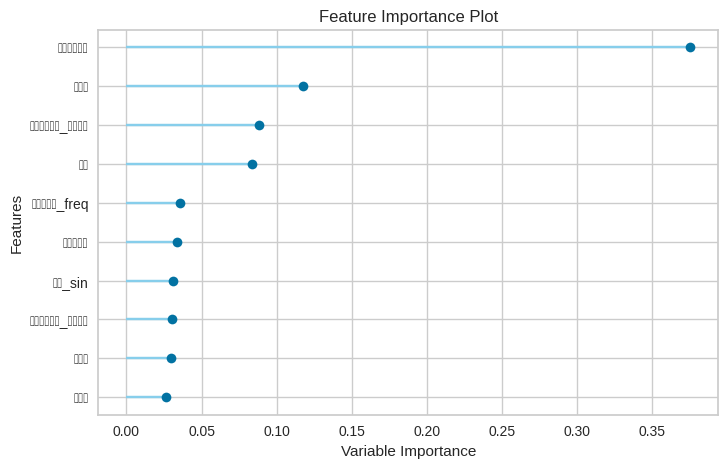

In [ ]:
from pycaret.classification import *

clf = setup(
    data=df_other,
    target='허위매물여부',
    train_size=0.8,
    session_id=42,
    verbose=False,
)

best_other_model = compare_models(sort='F1')
plot_model(best_other_model, plot='feature')
final_model_other = finalize_model(best_other_model)

In [ ]:
'''
from pycaret.classification import *
from imblearn.over_sampling import SMOTE

# PyCaret 세팅 + SMOTE 적용
clf = setup(
    data=df_other,
    target='허위매물여부',
    session_id=42,
    fix_imbalance=True,
    fix_imbalance_method=SMOTE(),
    train_size=0.8,
    verbose=False
)

best_model = compare_models(sort = 'F1')
tuned_model = tune_model(best_model, optimize='F1')
final_model = finalize_model(tuned_model)
'''

"\nfrom pycaret.classification import *\nfrom imblearn.over_sampling import SMOTE\n\n# PyCaret 세팅 + SMOTE 적용\nclf = setup(\n    data=df_other,\n    target='허위매물여부',\n    session_id=42,\n    fix_imbalance=True,\n    fix_imbalance_method=SMOTE(),\n    train_size=0.8,\n    verbose=False\n)\n\nbest_model = compare_models(sort = 'F1')\ntuned_model = tune_model(best_model, optimize='F1')\nfinal_model = finalize_model(tuned_model)\n"

In [ ]:
'''
# model ensemble
top3 = compare_models(n_select=3)
blended = blend_models(estimator_list=top3, optimize='F1')
final_model = finalize_model(blended)
'''

"\n# model ensemble\ntop3 = compare_models(n_select=3)\nblended = blend_models(estimator_list=top3, optimize='F1')\nfinal_model = finalize_model(blended)\n"

In [ ]:
# 파라미터튜닝

tuned_model = tune_model(
    final_model_other,
    optimize='F1',
    n_iter=30,
    choose_better=True,
    custom_grid={
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1.0]
    }
)
final_model = finalize_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9624,0.9732,0.8333,0.9524,0.8889,0.8664,0.8692
1,0.9624,0.9881,0.9167,0.8800,0.8980,0.8749,0.8752
2,0.9545,0.9410,0.8696,0.8696,0.8696,0.8420,0.8420
3,0.9470,0.9438,0.8261,0.8636,0.8444,0.8125,0.8128
4,0.9697,0.9892,0.8333,1.0000,0.9091,0.8911,0.8964
5,0.9470,0.9734,0.8333,0.8696,0.8511,0.8188,0.8191
6,0.9470,0.9722,0.8333,0.8696,0.8511,0.8188,0.8191
7,0.9242,0.9826,0.7917,0.7917,0.7917,0.7454,0.7454
8,0.9697,0.9907,0.8750,0.9545,0.9130,0.8947,0.8960


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 24 candidates, totalling 240 fits


In [ ]:
# 파라미터 튜닝 ver.2
'''
tuned_model = tune_model(
    final_model_other,
    optimize='F1',
    n_iter=40,
    choose_better=True,
    custom_grid={
        'max_depth': [3, 5, 7, 10, 15],  # 범위 확장
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300, 500],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],  # `colsample_bytree` 추가
        'reg_alpha': [0, 0.1, 1, 10],  # L1 정규화 추가
        'reg_lambda': [0, 0.1, 1, 10],  # L2 정규화 추가
    }
)
final_model = finalize_model(tuned_model)
'''

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9624,0.9736,0.8333,0.9524,0.8889,0.8664,0.8692
1,0.9624,0.9824,0.9167,0.8800,0.8980,0.8749,0.8752
2,0.9470,0.9473,0.8261,0.8636,0.8444,0.8125,0.8128
3,0.9470,0.9458,0.8261,0.8636,0.8444,0.8125,0.8128
4,0.9621,0.9834,0.7917,1.0000,0.8837,0.8615,0.8698
5,0.9545,0.9780,0.8333,0.9091,0.8696,0.8421,0.8433
6,0.9545,0.9745,0.8750,0.8750,0.8750,0.8472,0.8472
7,0.9394,0.9780,0.8333,0.8333,0.8333,0.7963,0.7963
8,0.9697,0.9892,0.8750,0.9545,0.9130,0.8947,0.8960


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [ ]:
# optuna 사용해서 파라미터 튜닝
'''
tuned_model = tune_model(
    estimator=final_model_other,
    optimize='F1',
    search_library='optuna',
    search_algorithm='tpe',
    n_iter=50,
    choose_better=True
)

final_model = finalize_model(tuned_model)
'''

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9624,0.9752,0.8333,0.9524,0.8889,0.8664,0.8692
1,0.9699,0.9836,0.9167,0.9167,0.9167,0.8983,0.8983
2,0.9545,0.9446,0.8696,0.8696,0.8696,0.8420,0.8420
3,0.9470,0.9378,0.8261,0.8636,0.8444,0.8125,0.8128
4,0.9621,0.9907,0.8333,0.9524,0.8889,0.8662,0.8690
5,0.9470,0.9599,0.8333,0.8696,0.8511,0.8188,0.8191
6,0.9470,0.9703,0.8750,0.8400,0.8571,0.8246,0.8249
7,0.9318,0.9811,0.8333,0.8000,0.8163,0.7745,0.7747
8,0.9773,0.9907,0.8750,1.0000,0.9333,0.9197,0.9227


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 1322 samples...
INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


In [ ]:
# ensemble
'''
xgb = tune_model(create_model('xgboost'), optimize='F1', n_iter=30)
lgbm = tune_model(create_model('lightgbm'), optimize='F1', n_iter=30)


stacked = stack_models([xgb, lgbm], meta_model=create_model('lr'), optimize='F1')
final_model = finalize_model(stacked)
'''

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9549,0.9759,0.7917,0.9500,0.8636,0.8369,0.8419
1,0.9624,0.9755,0.9167,0.8800,0.8980,0.8749,0.8752
2,0.9394,0.9509,0.7826,0.8571,0.8182,0.7819,0.7831
3,0.9470,0.9366,0.8261,0.8636,0.8444,0.8125,0.8128
4,0.9697,0.9857,0.8333,1.0000,0.9091,0.8911,0.8964
5,0.9394,0.9784,0.7917,0.8636,0.8261,0.7895,0.7906
6,0.9394,0.9769,0.8333,0.8333,0.8333,0.7963,0.7963
7,0.9394,0.9830,0.8750,0.8077,0.8400,0.8027,0.8037
8,0.9773,0.9865,0.8750,1.0000,0.9333,0.9197,0.9227


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9624,0.9702,0.8333,0.9524,0.8889,0.8664,0.8692
1,0.9624,0.9832,0.9167,0.8800,0.8980,0.8749,0.8752
2,0.9545,0.9465,0.8696,0.8696,0.8696,0.8420,0.8420
3,0.9470,0.9378,0.8261,0.8636,0.8444,0.8125,0.8128
4,0.9773,0.9896,0.9167,0.9565,0.9362,0.9224,0.9227
5,0.9394,0.9742,0.8333,0.8333,0.8333,0.7963,0.7963
6,0.9394,0.9715,0.9167,0.7857,0.8462,0.8087,0.8124
7,0.9394,0.9834,0.9167,0.7857,0.8462,0.8087,0.8124
8,0.9545,0.9853,0.9167,0.8462,0.8800,0.8520,0.8531


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 30 candidates, totalling 300 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9624,0.9736,0.8333,0.9524,0.8889,0.8664,0.8692
1,0.9624,0.9817,0.9167,0.8800,0.8980,0.8749,0.8752
2,0.9394,0.9525,0.7826,0.8571,0.8182,0.7819,0.7831
3,0.9470,0.9298,0.8261,0.8636,0.8444,0.8125,0.8128
4,0.9470,0.9846,0.7083,1.0000,0.8293,0.7990,0.8156
5,0.9545,0.9691,0.8333,0.9091,0.8696,0.8421,0.8433
6,0.9470,0.9715,0.8333,0.8696,0.8511,0.8188,0.8191
7,0.9394,0.9830,0.8333,0.8333,0.8333,0.7963,0.7963
8,0.9773,0.9880,0.8750,1.0000,0.9333,0.9197,0.9227


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,0.9706,0.7500,0.9474,0.8372,0.8063,0.8142
1,0.9624,0.9855,0.9167,0.8800,0.8980,0.8749,0.8752
2,0.9621,0.9430,0.8696,0.9091,0.8889,0.8661,0.8664
3,0.9470,0.9462,0.8261,0.8636,0.8444,0.8125,0.8128
4,0.9621,0.9927,0.8333,0.9524,0.8889,0.8662,0.8690
5,0.9394,0.9618,0.7500,0.9000,0.8182,0.7822,0.7869
6,0.9318,0.9672,0.8333,0.8000,0.8163,0.7745,0.7747
7,0.9318,0.9830,0.7917,0.8261,0.8085,0.7671,0.7673
8,0.9773,0.9911,0.8750,1.0000,0.9333,0.9197,0.9227


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 30 candidates, totalling 300 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.9362,0.4583,0.6471,0.5366,0.4550,0.4645
1,0.8722,0.9511,0.5000,0.7059,0.5854,0.5124,0.5231
2,0.8636,0.8907,0.3913,0.6923,0.5000,0.4280,0.4514
3,0.8788,0.9270,0.4783,0.7333,0.5789,0.5118,0.5278
4,0.8712,0.9495,0.5000,0.7059,0.5854,0.5117,0.5224
5,0.8864,0.9402,0.4583,0.8462,0.5946,0.5352,0.5693
6,0.8258,0.9074,0.4583,0.5238,0.4889,0.3844,0.3857
7,0.8636,0.9475,0.4583,0.6875,0.5500,0.4734,0.4869
8,0.8939,0.9711,0.5000,0.8571,0.6316,0.5746,0.6031


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9624,0.9706,0.8333,0.9524,0.8889,0.8664,0.8692
1,0.9624,0.9824,0.9167,0.8800,0.8980,0.8749,0.8752
2,0.9394,0.9477,0.7826,0.8571,0.8182,0.7819,0.7831
3,0.9470,0.9370,0.8261,0.8636,0.8444,0.8125,0.8128
4,0.9470,0.9884,0.7500,0.9474,0.8372,0.8060,0.8139
5,0.9470,0.9730,0.8333,0.8696,0.8511,0.8188,0.8191
6,0.9242,0.9711,0.8333,0.7692,0.8000,0.7534,0.7543
7,0.9318,0.9834,0.8333,0.8000,0.8163,0.7745,0.7747
8,0.9773,0.9850,0.8750,1.0000,0.9333,0.9197,0.9227


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
train_preds = predict_model(final_model)
y_true = train_preds['허위매물여부']

from sklearn.metrics import f1_score
import numpy as np

best_f1 = 0
best_threshold = 0

for t in np.arange(0.3, 0.7, 0.01):
    y_pred = (train_preds['prediction_score'] > t).astype(int)
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"최적 Threshold: {best_threshold:.2f} → F1 Score: {best_f1:.4f}")


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9970,1.0000,1.0000,0.9836,0.9917,0.9899,0.9899


최적 Threshold: 0.52 → F1 Score: 0.3077


### Predict
- test에도 train과 같은 전처리 후 predict 진행

In [ ]:
test_df = test.copy()

In [ ]:
# 중개사무소
agency_freq = test_df['중개사무소'].value_counts()
test_df['중개사무소_freq'] = test_df['중개사무소'].map(agency_freq)

# 제공플랫폼
platform_freq = test_df['제공플랫폼'].value_counts()
test_df['제공플랫폼_freq'] = test_df['제공플랫폼'].map(platform_freq)

In [ ]:
test_df['결측치_개수'] = test_df.isnull().sum(axis=1)

mode_cols = ['욕실수']

for col in mode_cols:
    test_df[col].fillna(test_df[col].mode().iloc[0], inplace=True)

median_cols = ['전용면적', '해당층', '총층', '총주차대수']
for col in median_cols:
    test_df[col].fillna(test_df[col].median(), inplace=True)

In [ ]:
test_df['방향_정리'] = test_df['방향'].apply(clean_direction)

test_df['방향_angle'] = test_df['방향_정리'].map(direction_to_angle)
test_df['방향_sin'] = np.sin(np.deg2rad(test_df['방향_angle']))
test_df['방향_cos'] = np.cos(np.deg2rad(test_df['방향_angle']))

In [ ]:
test_df['게재일'] = pd.to_datetime(test_df['게재일'])
today = pd.to_datetime('today')
test_df['등록후경과일'] = (today - test_df['게재일']).dt.days

In [ ]:
test_df['게재일'] = pd.to_datetime(test_df['게재일'], errors='coerce')

test_df['등록연'] = test_df['게재일'].dt.year
test_df['등록월'] = test_df['게재일'].dt.month
test_df['등록일'] = test_df['게재일'].dt.day
test_df['등록분기'] = test_df['게재일'].dt.quarter

In [ ]:
target_agency = 'G52Iz8V2B9'

test_df_g52 = test_df[test_df['중개사무소'] == target_agency].copy()
test_df_other = test_df[test_df['중개사무소'] != target_agency].copy()

In [ ]:
test_df_g52.drop(columns=['ID', '방향', '방향_정리', '방향_angle', '게재일'], axis=1, inplace=True)
test_df_other.drop(columns=['ID', '방향', '방향_정리', '방향_angle', '게재일'], axis=1, inplace=True)

In [ ]:
test_df_g52.drop(columns=['중개사무소', '제공플랫폼', '방향_cos', '등록일'], inplace=True)
test_df_other.drop(columns=['중개사무소', '제공플랫폼', '방향_cos', '등록일'], inplace=True)

In [ ]:
preds_other = predict_model(final_model, data=test_df_other)
preds_other['허위매물여부'] = (preds_other['prediction_score'] > 0.52).astype(int)
preds_other.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,매물확인방식,보증금,월세,전용면적,해당층,총층,방수,욕실수,주차가능여부,총주차대수,...,결측치_개수,방향_sin,등록후경과일,등록연,등록월,등록분기,ID,허위매물여부,prediction_label,prediction_score
0,서류확인,223000000.0,530000,27.219999,5.0,5.0,1.0,1.0,불가능,11.5,...,2,1.000000e+00,164,2024,10,4,TEST_000,1,0,0.9764
2,현장확인,47000000.0,200000,41.500000,2.0,3.0,2.0,1.0,불가능,11.5,...,1,7.071068e-01,365,2024,4,2,TEST_002,1,1,0.9271
3,서류확인,133000000.0,250000,31.350000,5.0,6.0,2.0,1.0,가능,11.5,...,1,1.000000e+00,196,2024,9,3,TEST_003,1,0,0.9751
4,현장확인,108000000.0,380000,23.139999,2.0,3.0,1.0,1.0,불가능,11.5,...,1,1.000000e+00,144,2024,11,4,TEST_004,1,0,0.9765
5,현장확인,23000000.0,420000,27.219999,3.0,4.0,2.0,1.0,불가능,11.5,...,3,1.224647e-16,100,2024,12,4,TEST_005,1,0,0.9765


## Submission

In [ ]:
test_df_g52['허위매물여부'] = 0
test_df_other['허위매물여부'] = preds_other['prediction_label']

test_df_g52['ID'] = test.loc[test_df_g52.index, 'ID']
test_df_other['ID'] = test.loc[test_df_other.index, 'ID']

In [ ]:
final_submission = pd.concat([
    test_df_g52[['ID', '허위매물여부']],
    test_df_other[['ID', '허위매물여부']]
])

# 정렬 + 저장
final_submission = final_submission.sort_values('ID').reset_index(drop=True)
final_submission.to_csv('submission23.csv', index=False)